## 01_3D_grid_figure  
This notebook makes the 3D grid figure shown in the E3DSECS paper  
  
Start by setting the working directory and make python find the e3dsecs package

In [1]:
import os
notebook_file_path = os.path.realpath('__file__')
os.chdir(os.path.dirname(notebook_file_path))
import sys
parent_directory = os.path.dirname(notebook_file_path)
e3dsecsdir = os.path.abspath(os.path.join(parent_directory, '..'))
sys.path.append(e3dsecsdir)

Import the packages needed

In [2]:
from e3dsecs import simulation, grid, coordinates, visualization
import numpy as np
from gemini3d.grid.convert import geomag2geog
import gemini3d.read as read
import xarray as xr
import matplotlib.pyplot as plt

Set various options

In [3]:
path            = '/Users/jone/Documents/uib/gemini_output/'
                        # Adjust to fit your system to find the GEMINI files
alt_layers      = np.concatenate((np.arange(90,140,5),np.arange(140,170,10), 
                                    np.arange(170,230,20),np.arange(230,500,50)))
                        # The vertical layers to be used
sitelat         = 67.7 # Gegraphic latitude of transmitter site location. Skibotn: 69.39
sitephi         = 23.0  # Gegraphic longitude of transmitter site location. Skibotn: 20.27

Make object containing simulation data (sim) and grid (gr)

In [4]:
sim = simulation.simulation(path)
gr = grid.grid(sim, alts=alt_layers, orientation=-26)

### Make the f3D grid figure

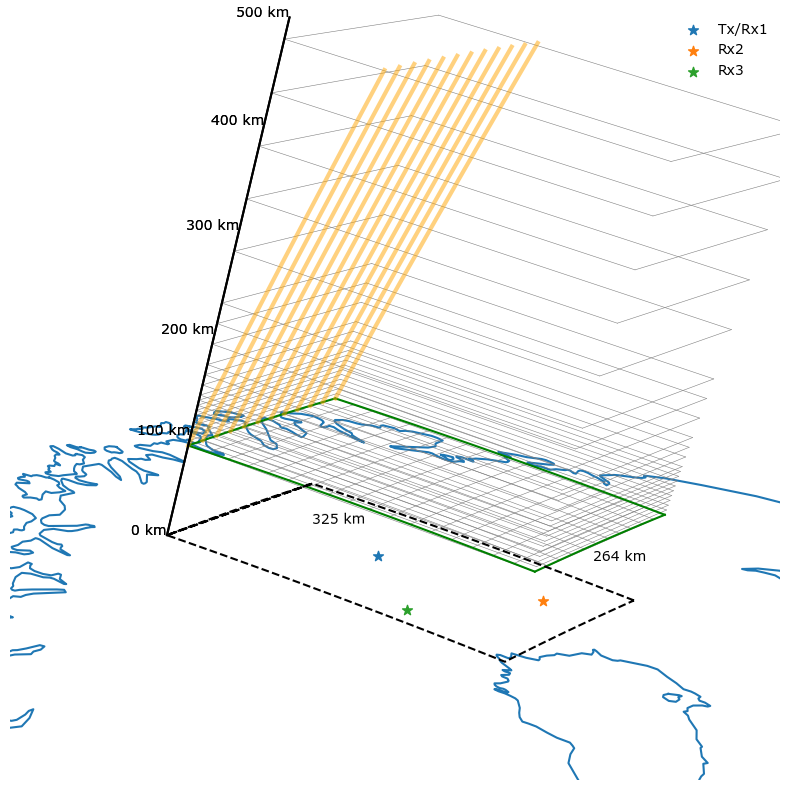

In [5]:
fig = plt.figure(figsize = (10, 10))
ax = fig.add_subplot(111, projection='3d')
ax.set_axis_off()
visualization.field_aligned_grid(ax, gr.grid, gr.alts_grid, color='green', showlayers=True, 
                       showbase=True, fullbox=False, verticalcorners=False, 
                       dipoleB=False)
kwargs={'linewidth':3}
lat = gr.grid.lat_mesh[-1,:]
lon = gr.grid.lon_mesh[-1,:]
for kk in range(lat.size):
    visualization.plot_field_line(ax, lat[kk], lon[kk], 
                              gr.alts_grid, color='orange', **kwargs, dipoleB=True)

# Plot vertical height scale
alts = np.array([0,100,200,300,400,500])
N = len(alts)
lats = np.array([gr.grid.lat_mesh[-1,0]]*N)
lons = np.array([gr.grid.lon_mesh[-1,0]]*N)
L = gr.grid.L*1e-3
Lres = gr.grid.Lres*1e-3
pos = gr.grid.projection.position
x_, y_, z_ = coordinates.sph_to_car((sim.RE+alts, 90-lats, lons), deg=True)
ax.plot(x_, y_, z_, color='black')
for (ii,aa) in enumerate(alts):
    ax.text(x_[ii], y_[ii], z_[ii], str(aa)+' km', ha='right')
    
# Plot projecte frame on ground level
lats = np.hstack((gr.grid.lat_mesh[:,-1],gr.grid.lat_mesh[-1,:],gr.grid.lat_mesh[:,0][::-1],gr.grid.lat_mesh[0,:]))
lons = np.hstack((gr.grid.lon_mesh[:,-1],gr.grid.lon_mesh[-1,:],gr.grid.lon_mesh[:,0][::-1],gr.grid.lon_mesh[0,:]))

x_, y_, z_ = coordinates.sph_to_car((sim.RE+0, 90-lats, lons), deg=True)
ax.plot(x_, y_, z_, '--', color='black')

# Add E3D sites
dlat = 69.39- sitelat
dlon = 20.26 - sitephi
lats0 = np.array([69.39, 68.44, 68.37]) # Actual locations
lons0 = np.array([20.26, 22.48, 19.10]) # Actual locations
lats = np.array([sitelat, lats0[1]-dlat, lats0[2]-dlat])
lons = np.array([sitephi, lons0[1]-dlon, lons0[2]-dlon])
alts = np.array([0,0,0])
# sites = ['Skibotn', 'Karesuando', 'Kaiseniemi']
sites = ['Tx/Rx1', 'Rx2', 'Rx3']
x, y, z = coordinates.sph_to_car((sim.RE+alts, 90-lats, lons), deg=True)
for i,s in enumerate(sites):
    ax.scatter(x[i], y[i], z[i], label=s, marker='*', s=55)
ax.legend(frameon=False)

# Add grid dimensions
alt = int(gr.alts_grid[0]) - 20
sh = gr.grid.shape
# glon, glat = geomag2geog(np.radians(grid.lon[sh[0]//2,0]), np.radians(90-grid.lat[sh[0]//2,0]))
glon = gr.grid.lon[sh[0]//2+5,0] 
glat = gr.grid.lat[sh[0]//2,0]
x_, y_, z_ = coordinates.sph_to_car((sim.RE+alt, 90-glat, glon), deg=True)
w = int(np.round(gr.grid.W/1000))
ax.text(x_[0], y_[0], z_[0], '%3i km' % w, 'y', fontsize=10) 

glon = gr.grid.lon[0,sh[1]//2] 
glat = gr.grid.lat[0,sh[1]//2-1]
x_, y_, z_ = coordinates.sph_to_car((sim.RE+alt, 90-glat, glon), deg=True)
l = int(np.round(gr.grid.L/1000))
ax.text(x_[0], y_[0], z_[0], '%3i km' % l, fontsize=10) 

# Fix viewing geometry
lat_ = gr.grid.projection.position[1] # in degrees
lon_ = gr.grid.projection.position[0] # in degrees
L = gr.grid.L*1e-3
Lres = gr.grid.Lres*1e-3
x_, y_, z_ = coordinates.sph_to_car((sim.RE, 90-lat_, lon_), deg=True)
xlim = (x_[0]-L+3*Lres, x_[0]+L-3*Lres) 
ylim = (y_[0]-L+3*Lres, y_[0]+L-3*Lres) 
# zlim = (RE, RE+alts_grid[-1]+1)
zlim = (z_[0], z_[0]+ 0.7*gr.alts_grid[-1])
ax.set_xlim(xlim)
ax.set_ylim(ylim)
# ax.set_zlim(5600,6400)
ax.set_zlim(zlim)
ax.view_init(azim=-15, elev=0)
fig.savefig('./plots/3dgrid_figure.pdf', dpi=250,bbox_inches='tight')